In [1]:
import torch
import tqdm
import pandas as pd
from torcheval.metrics import BinaryConfusionMatrix

In [2]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, samples,features,func):
        self.samples=samples
        self.features=features
        self.x =torch.rand([samples,features])
        self.y=torch.where( func(self.x) ,1,0)
        print(self.y.sum()/self.y.shape[0])
        print(self.y.shape)

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        return self.x[idx],self.y[idx].unsqueeze(0)

In [3]:
class HiddenLayer(torch.nn.Module):
    def __init__(self,features):
        super(HiddenLayer, self).__init__()    
        self.first = torch.nn.Linear(features, features)  # Input size is 2 (1st and last features), 64 hidden units
        self.relu = torch.nn.ReLU()  

    def forward(self, x):
        x = self.first(x)
        x = self.relu(x)
        return x
class SimpleModel(torch.nn.Module):
    def __init__(self,features,embeding,hidden,hidden_layers):
        super(SimpleModel, self).__init__()
        # Define a neural network with a few layers to learn nonlinear relationships
        self.enc=torch.nn.Sequential(
            torch.nn.Linear(features, embeding),
            torch.nn.ReLU(),
            torch.nn.Linear(embeding, hidden),
            torch.nn.ReLU()
        )
        self.layers = torch.nn.ModuleList(
            [
                HiddenLayer(hidden)
                for i in range(hidden_layers)
            ]
        )
        self.dec=torch.nn.Sequential(
            torch.nn.Linear(hidden, embeding),
            torch.nn.ReLU()
        )
        self.last = torch.nn.Linear(embeding, 1)  # Output layer, 1 unit (binary classification)
        self.sigmoid = torch.nn.Sigmoid()  # Sigmoid for binary classification output

    def forward(self, x):
        x = self.enc(x)
        for layer in self.layers:
            x = layer(x)
        x = self.dec(x)
        x = self.last(x)
        x = self.sigmoid(x)
        return x

In [19]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self,features,embeding,hidden,hidden_layers):
        super().__init__()
        self.conv1 = GCNConv(1, embeding)
        self.conv2 = GCNConv(embeding, hidden)
        self.layers = torch.nn.ModuleList(
            [
                GCNConv(hidden, hidden)
                for i in range(hidden_layers)
            ]
        )
        self.conv3 = GCNConv(hidden, 1)
        self.last = torch.nn.Linear(features, 1)  # Output layer, 1 unit (binary classification)
        self.sigmoid = torch.nn.Sigmoid()  # Sigmoid for binary classification output
        self.edge_index=torch.tensor([[0,features-1],[features-1,0]]).cuda()

    def forward(self, data:torch.Tensor):
        x = self.conv1(data.unsqueeze(-1), self.edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, self.edge_index)
        for layer in self.layers:
            x = layer(x, self.edge_index)
            x = F.relu(x)
            # x = F.dropout(x, training=self.training)
        x = self.conv3(x, self.edge_index)
        x = F.relu(x)
        x = self.last(x.squeeze(-1))
        x = self.sigmoid(x)
        return x

In [5]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    model.cuda()
    metric=BinaryConfusionMatrix()
    with torch.no_grad():  # Disable gradient computation for testing
        t=tqdm.tqdm(test_loader,leave=False)
        for features, labels in t:
            # Forward pass
            outputs = model(features.detach().cuda())
            
            # Assuming binary classification: outputs are probabilities
            # predicted = torch.where((outputs > 0.5),1,0).float()  # Convert probabilities to binary predictions
            metric.update(outputs.squeeze(),labels.squeeze())
            # Calculate accuracy
            # total += labels.size(0)
            # correct += (predicted.cpu() == labels).sum().item()
    r=metric.compute().tolist()
    # accuracy = 100 * correct / total
    return r[0][0]/(r[0][0]+r[0][1]),r[1][1]/(r[1][0]+r[1][1])

In [6]:
# Example training loop
def train_model(model:torch.nn.Module, 
                train_data_loader:torch.utils.data.DataLoader, 
                test_data_loader:torch.utils.data.DataLoader,
                epochs:int):
    criterion = torch.nn.MSELoss() # Binary Cross-Entropy Loss for classification
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model=model.train().cuda()
    t=tqdm.tqdm(torch.arange(epochs))
    t.set_postfix_str("{Loss:.4f}")
    train_p_recall=[]
    train_n_recall=[]
    test_p_recall=[]
    test_n_recall=[]   
    _loss=[]
    for epoch in t:
        for features, labels in train_data_loader:
            # Extract the 1st and last features only
            # x = features[:, [0, -1]]  # Select 1st and last feature
            # labels = labels.view(-1, 1)  # Reshape labels for BCELoss
            
            # Forward pass
            outputs = model(features.cuda())
            loss = criterion(outputs, labels.cuda().float())
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        t.set_postfix({"Loss": loss.item()})
        _loss.append(loss.item())
        rtrain=test_model(model,train_data_loader)
        rtest=test_model(model,test_data_loader)
        train_p_recall.append(rtrain[0])
        train_n_recall.append(rtrain[1])
        test_p_recall.append(rtest[0])
        test_n_recall.append(rtest[1])
        
    return pd.DataFrame({"train_p_recall":train_p_recall,
                         "train_n_recall":train_n_recall,
                         "test_p_recall":train_p_recall,
                         "test_n_recall":test_n_recall,
                         "loss":_loss})
        

# Note: You need to provide a data loader (`data_loader`) that yields batches of your dataset.


In [8]:
def NonLinear(x:torch.Tensor):
    return (x[:, 0]**2+x[:, -1]**2-x[:, 0] * x[:, -1])>.7

In [20]:
samples=10000
features=5

noram_dataset=CustomDataset(samples,features,NonLinear)
abnoram_dataset=CustomDataset(samples,features,NonLinear)


tensor(0.1552)
torch.Size([10000])
tensor(0.1534)
torch.Size([10000])


In [21]:
normal_loader=torch.utils.data.DataLoader(noram_dataset,64,shuffle=True)
abnormal_loader=torch.utils.data.DataLoader(abnoram_dataset,64)
# Instantiate the model, loss function, and optimizer
# model = SimpleModel(features,64,32,0)
model=GCN(features,64,32,0)



In [22]:

result=train_model(model=model,
                   train_data_loader=normal_loader,
                   test_data_loader=abnormal_loader,
                   epochs=50)
result.iloc[-1]

100%|██████████| 50/50 [02:50<00:00,  3.41s/it, Loss=0.0672]


train_p_recall    1.000000
train_n_recall    0.000000
test_p_recall     1.000000
test_n_recall     0.000000
loss              0.067235
Name: 49, dtype: float64

In [35]:
yp.squeeze().mean()

tensor(0.1554, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:

model.eval()
yp=model(noram_dataset.x.cuda())
c=BinaryConfusionMatrix()
c.update(noram_dataset.y.detach(),yp.detach().squeeze())
c.compute()

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript (most recent call last):
  File "c:\Users\moji\miniconda3\envs\cuda_12_4\Lib\site-packages\torcheval\metrics\functional\classification\confusion_matrix.py", line 232, in _update

    # Each prediction creates an entry at the position (true, pred)
    sparse_cm = torch.sparse_coo_tensor(coordinates, torch.ones_like(target), cm_shape)
                ~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE

    return sparse_cm.to_dense()
RuntimeError: indices must be an int64 tensor


In [314]:
result.loc[150:,"loss"].mean()

nan

<Axes: >

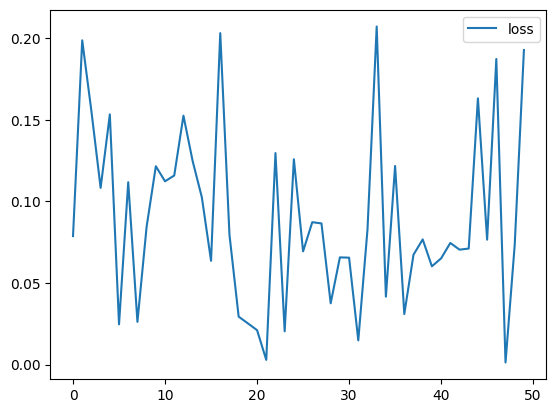

In [26]:
result.plot(y=["loss"])

<Axes: >

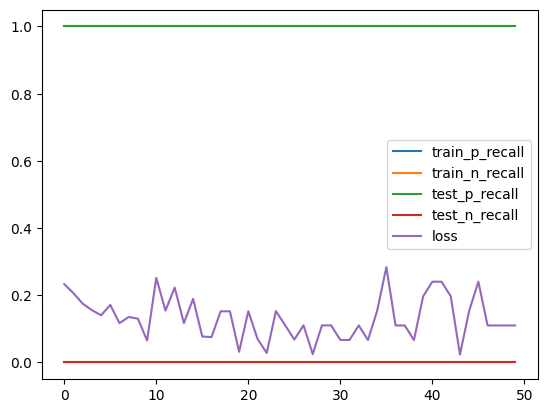

In [48]:
result.iloc[:].plot()